In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mkdir -p /content/drive/MyDrive/COCO

In [ ]:
%cd /content/drive/MyDrive/COCO
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

In [43]:
!pip install diffusers transformers accelerate torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 124.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1


In [2]:
# point to dataset paths
data_dir = "/content/drive/MyDrive/COCO"
images_path = f"{data_dir}/val2017"
annotations_path = f"{data_dir}/annotations/captions_val2017.json"

In [3]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os
import json
from glob import glob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

## Data Preparation Functions

In [4]:
#Converting JSON to CSV

import json, csv
#Load annotations json
with open(annotations_path, "r") as f:
  ann= json.load(f)

#Map image_id --> file_name
id2file= {img['id']: img['file_name'] for img in ann['images']}

#Create rows
rows= []
for a in ann["annotations"]:
  rows.append([id2file[a['image_id']], a['caption']])

# Save CSV
os.makedirs(data_dir, exist_ok=True)
out_csv = f"{data_dir}/captions_val2017.csv"
with open(out_csv, "w", newline="", encoding="utf8") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "caption"])  # CSV header
    writer.writerows(rows)

In [5]:
ann

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
   'id': 2,
   'name': 'Attribution-NonCommercial License'},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 3,
   'name': 'Attribution-NonCommercial-NoDerivs License'},
  {'url': 'http://creativecommons.org/licenses/by/2.0/',
   'id': 4,
   'name': 'Attribution License'},
  {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
   'id': 5,
   'name': 'Attribution-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
   'id': 6,
   'name': 'Attribution-NoDerivs License'},
  {'url': 'http://flickr.com/commons/usage/',
   'id': 7,
   'name': 'No kn

In [6]:
data_csv= pd.read_csv(out_csv)

In [7]:
data_csv

file_name                                            caption
0      000000179765.jpg  A black Honda motorcycle parked in front of a ...
1      000000179765.jpg      A Honda motorcycle parked in a grass driveway
2      000000190236.jpg  An office cubicle with four different types of...
3      000000331352.jpg          A small closed toilet in a cramped space.
4      000000517069.jpg     Two women waiting at a bench next to a street.
...                 ...                                                ...
25009  000000009590.jpg  A group of men sipping drinks and talking at a...
25010  000000084664.jpg  A plate of food with some eggs, potatoes, brea...
25011  000000331569.jpg  The strawberries was sitting beside the tall g...
25012  000000231237.jpg  A bunch of small red flowers in a barnacle enc...
25013  000000386134.jpg         Food is in a styrofoam take out container.

[25014 rows x 2 columns]

In [8]:
unique_images= data_csv['file_name'].unique()
unique_images

array(['000000179765.jpg', '000000190236.jpg', '000000331352.jpg', ...,
       '000000541634.jpg', '000000064084.jpg', '000000537802.jpg'],
      dtype=object)

In [9]:
len(unique_images)

5000

## Splitting Of Data

In [10]:
train_imgs, temp_imgs= train_test_split(unique_images, test_size= 0.2, random_state= 42)
val_imgs, test_imgs= train_test_split(temp_imgs, test_size= 0.5, random_state= 42)

In [11]:
def assign_split(fname):
    if fname in train_imgs:
        return "train"
    elif fname in val_imgs:
        return "val"
    else:
        return "test"

In [12]:
data_csv['split'] = data_csv['file_name'].apply(assign_split)

In [13]:
data_csv

file_name                                            caption  \
0      000000179765.jpg  A black Honda motorcycle parked in front of a ...   
1      000000179765.jpg      A Honda motorcycle parked in a grass driveway   
2      000000190236.jpg  An office cubicle with four different types of...   
3      000000331352.jpg          A small closed toilet in a cramped space.   
4      000000517069.jpg     Two women waiting at a bench next to a street.   
...                 ...                                                ...   
25009  000000009590.jpg  A group of men sipping drinks and talking at a...   
25010  000000084664.jpg  A plate of food with some eggs, potatoes, brea...   
25011  000000331569.jpg  The strawberries was sitting beside the tall g...   
25012  000000231237.jpg  A bunch of small red flowers in a barnacle enc...   
25013  000000386134.jpg         Food is in a styrofoam take out container.   

       split  
0      train  
1      train  
2      train  
3      train  
4      train  
...      ...  
25009  train  
25010   test  
25011  train  
25012    val  
25013  train  

[25014 rows x 3 columns]

In [14]:
# Making dfs
train_df= data_csv[data_csv['split'] == 'train'].reset_index(drop=True)
val_df= data_csv[data_csv['split'] == 'val'].reset_index(drop=True)
test_df= data_csv[data_csv['split'] == 'test'].reset_index(drop=True)

In [15]:
train_df

file_name                                            caption  \
0      000000179765.jpg  A black Honda motorcycle parked in front of a ...   
1      000000179765.jpg      A Honda motorcycle parked in a grass driveway   
2      000000190236.jpg  An office cubicle with four different types of...   
3      000000331352.jpg          A small closed toilet in a cramped space.   
4      000000517069.jpg     Two women waiting at a bench next to a street.   
...                 ...                                                ...   
20007  000000537802.jpg  Three stuffed bears wearing clothes riding on ...   
20008  000000537802.jpg  A set of plush toy teddy bears sitting in a sled.   
20009  000000009590.jpg  A group of men sipping drinks and talking at a...   
20010  000000331569.jpg  The strawberries was sitting beside the tall g...   
20011  000000386134.jpg         Food is in a styrofoam take out container.   

       split  
0      train  
1      train  
2      train  
3      train  
4      train  
...      ...  
20007  train  
20008  train  
20009  train  
20010  train  
20011  train  

[20012 rows x 3 columns]

In [16]:
val_df

file_name                                            caption  \
0     000000012667.jpg  The telephone has a banana where the receiver ...   
1     000000012667.jpg  A banana replacing the phone on an answering m...   
2     000000012667.jpg  A phone with a banana where the receiver shoul...   
3     000000012667.jpg  A telephone has it receiver replaced with a ba...   
4     000000226662.jpg  A customized motorcycle with more in the backg...   
...                ...                                                ...   
2497  000000064084.jpg           a plate with some pieces of bread on it    
2498  000000064084.jpg  Sliced french bread is on a plat that is lying...   
2499  000000064084.jpg  Bread that is sitting on a plate that is on a ...   
2500  000000064084.jpg  A white plate with lots topped with garlic bread.   
2501  000000231237.jpg  A bunch of small red flowers in a barnacle enc...   

     split  
0      val  
1      val  
2      val  
3      val  
4      val  
...    ...  
2497   val  
2498   val  
2499   val  
2500   val  
2501   val  

[2502 rows x 3 columns]

In [17]:
test_df

file_name                                            caption  \
0     000000472678.jpg    An office cubicle with multiple computers in it   
1     000000472678.jpg       An office desk with two flat panel monitors.   
2     000000338325.jpg  A striped plane flying up into the sky as the ...   
3     000000338325.jpg        An airplane is ascending into the white sky   
4     000000338325.jpg           An American Airlines plane is in the sky   
...                ...                                                ...   
2495  000000142620.jpg   a man that is sitting in front of a picnic table   
2496  000000142620.jpg    A man sitting at a table outside eating a meal.   
2497  000000142620.jpg             A man eating out on a table and bench.   
2498  000000142620.jpg  The man is sitting outside with food on the ta...   
2499  000000084664.jpg  A plate of food with some eggs, potatoes, brea...   

     split  
0     test  
1     test  
2     test  
3     test  
4     test  
...    ...  
2495  test  
2496  test  
2497  test  
2498  test  
2499  test  

[2500 rows x 3 columns]

## Data Preprocessing

In [18]:
# Text Preprocessing
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Clean Captions
def clean_caption(caption):
  caption= caption.lower()
  caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)  # remove punctuation
  caption = re.sub(r"\s+", " ", caption).strip()    # remove extra spaces
  return caption

train_df['clean_caption'] = train_df['caption'].apply(clean_caption)
val_df['clean_caption']   = val_df['caption'].apply(clean_caption)

# 2. Fit tokenizer only on training captions
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(train_df['clean_caption'])

# Convert captions → integer sequences
train_seqs = tokenizer.texts_to_sequences(train_df['clean_caption'])
val_seqs   = tokenizer.texts_to_sequences(val_df['clean_caption'])

# Step 3: Pad sequences
max_len = max(len(seq) for seq in train_seqs)  # longest caption in train
train_seqs = pad_sequences(train_seqs, maxlen=max_len, padding="post")
val_seqs   = pad_sequences(val_seqs, maxlen=max_len, padding="post")

In [19]:
# Image Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
image_size= 64
def load_preprocess_img(img_path):
  img= cv2.imread(img_path) # load image
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR→RGB
  img= cv2.resize(img, (image_size, image_size)) # resize
  img = (img.astype(np.float32) - 127.5) / 127.5  # normalize to [-1, 1]
  return img

# Paths
imgs_dir= f"{data_dir}/val2017"

In [20]:
# Train imgs
train_imgs= []
for fname in tqdm(train_df['file_name']):
  path= os.path.join(imgs_dir, fname)
  train_imgs.append(load_preprocess_img(path))
train_imgs= np.array(train_imgs)

100%|██████████| 20012/20012 [30:13<00:00, 11.04it/s]


In [21]:
# Val imgs
val_imgs= []
for fname in tqdm(val_df['file_name']):
  path= os.path.join(imgs_dir, fname)
  val_imgs.append(load_preprocess_img(path))
val_imgs= np.array(val_imgs)

100%|██████████| 2502/2502 [03:51<00:00, 10.80it/s]


In [22]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_seqs, train_imgs))
val_dataset= tf.data.Dataset.from_tensor_slices((val_seqs, val_imgs))
buffer_size= 1000
batch_size= 32
# Shuffle, batch and prefetch for performance
train_dataset= (
    train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

val_dataset= (
    val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

In [23]:
buffer_size

1000

## Building The Model

In [24]:
VOCAB_SIZE = 5000
EMBED_DIM = embedding_dim= 256
SEQ_LEN = 38
IMG_SIZE = 64
NOISE_DIM = 100

### **What does the generator need?**

1. Text info → need embedding layer

2. Random noise → need noise input

3. Output → image → need upscaling layers

In [25]:
def build_generator(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, noise_dim= NOISE_DIM):
  # Text Input
  text_input= layers.Input(shape=(seq_len,), name= "text_input")
  x_text= layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(text_input)
  x_text= layers.Flatten()(x_text)
  # Random noise input
  noise_input= layers.Input(shape=(noise_dim,), name="noise_input")
  # Combine text embedding + noise
  x= layers.Concatenate()([x_text, noise_input])

  # Project to dense layer
  x= layers.Dense(8*8*128, activation="relu")(x)
  x= layers.Reshape((8,8, 128))(x)

  # Upsample to image size
  x= layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
  x= layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
  x= layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)

  return Model([text_input, noise_input], x, name="Generator")

In [35]:
from tensorflow.keras import layers, Model

def build_generator(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, noise_dim=NOISE_DIM):
    # Text input
    text_input = layers.Input(shape=(seq_len,), name="text_input")
    x_text = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(text_input)
    x_text = layers.Flatten()(x_text)
    x_text = layers.Dense(256, activation="relu")(x_text)  # project text embedding

    # Noise input
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    x_noise = layers.Dense(256, activation="relu")(noise_input)

    # Combine text + noise
    x = layers.Concatenate()([x_text, x_noise])
    x = layers.Dense(8*8*256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    # Upsample to image size
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)

    # Inject extra noise here for diversity
    extra_noise = layers.Input(shape=(noise_dim,), name="extra_noise")
    x_extra = layers.Dense(64, activation="relu")(extra_noise)
    x_extra = layers.Reshape((1, 1, 64))(x_extra)
    x_extra = layers.UpSampling2D(size=(32, 32))(x_extra)
    x = layers.Concatenate()([x, x_extra])

    x = layers.Conv2DTranspose(64, 4, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(3, 4, strides=1, padding="same", activation="tanh")(x)

    return Model([text_input, noise_input, extra_noise], x, name="Generator")


What does the discriminator need?

1. Image → Conv layers

2. Text → embedding

3. Combine → Dense → probability

In [26]:
def build_discriminator(seq_len=SEQ_LEN, vocab_size= VOCAB_SIZE, embed_dim=EMBED_DIM, img_size=IMG_SIZE):
  img_input= layers.Input(shape=(img_size, img_size, 3), name="img_input")
  x_img= layers.Conv2D(64, 4, strides=2, padding="same", activation= "leaky_relu") (img_input)
  x_img= layers.Conv2D(128, 4, strides=2, padding="same", activation= "leaky_relu") (x_img)
  x_img= layers.Flatten()(x_img)
  # Text Input
  text_input= layers.Input(shape=(seq_len,), name="text_input")
  x_text= layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(text_input)
  x_text= layers.Flatten()(x_text)
  # Combine image features + text embedding
  x= layers.Concatenate()([x_img, x_text])
  x= layers.Dense(256, activation="leaky_relu")(x)
  out= layers.Dense(1, activation="sigmoid")(x)

  return Model([img_input, text_input], out, name="Discriminator")

In [36]:
# Instantiating The Model

generator= build_generator()
discriminator= build_discriminator()

In [ ]:
EPOCHS = 5
NOISE_DIM = 100

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_gen_loss = 0
    train_disc_loss = 0

    for step, (text_seq, real_images) in enumerate(train_dataset):
        batch_size = text_seq.shape[0]
        noise = tf.random.normal([batch_size, NOISE_DIM])

        with tf.GradientTape(persistent=True) as tape:
            fake_images = generator([text_seq, noise], training=True)
            real_output = discriminator([real_images, text_seq], training=True)
            fake_output = discriminator([fake_images, text_seq], training=True)

            disc_loss = bce(tf.ones_like(real_output), real_output) + \
                        bce(tf.zeros_like(fake_output), fake_output)
            gen_loss = bce(tf.ones_like(fake_output), fake_output)

        gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
        disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

        train_gen_loss += gen_loss.numpy()
        train_disc_loss += disc_loss.numpy()

    train_gen_loss /= tf.data.experimental.cardinality(train_dataset).numpy()
    train_disc_loss /= tf.data.experimental.cardinality(train_dataset).numpy()

    print(f"Generator Loss: {train_gen_loss:.4f} | Discriminator Loss: {train_disc_loss:.4f}")

In [ ]:
def train_gan(train_ds, val_ds, generator, discriminator,
              noise_dim, gen_optimizer, disc_optimizer, epochs=5):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_gen_loss = 0
        train_disc_loss = 0

        for step, (text_seq, real_images) in enumerate(train_ds):
            batch_size = text_seq.shape[0]
            noise = tf.random.normal([batch_size, noise_dim])

            with tf.GradientTape(persistent=True) as tape:
                fake_images = generator([text_seq, noise], training=True)
                real_output = discriminator([real_images, text_seq], training=True)
                fake_output = discriminator([fake_images, text_seq], training=True)

                disc_loss = bce(tf.ones_like(real_output), real_output) + \
                            bce(tf.zeros_like(fake_output), fake_output)
                gen_loss = bce(tf.ones_like(fake_output), fake_output)

            gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
            disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

            train_gen_loss += gen_loss.numpy()
            train_disc_loss += disc_loss.numpy()

        steps = tf.data.experimental.cardinality(train_ds).numpy()
        train_gen_loss /= steps
        train_disc_loss /= steps

        print(f"Generator Loss: {train_gen_loss:.4f} | Discriminator Loss: {train_disc_loss:.4f}")

    return generator, discriminator, train_gen_loss, train_disc_loss


In [ ]:
save_dir = "/content/drive/MyDrive/COCO/text2image_gan"
os.makedirs(save_dir, exist_ok=True)

# Save the entire model
generator.save(f"{save_dir}/generator_model.keras")
discriminator.save(f"{save_dir}/discriminator_model.keras")

# Save weights separately
generator.save_weights(f"{save_dir}/generator_weights.weights.h5")
discriminator.save_weights(f"{save_dir}/discriminator_weights.weights.h5")

In [ ]:
from keras.models import load_model

# Load full models
generator = load_model("/content/drive/MyDrive/COCO/text2image_gan/generator_model.keras")
discriminator = load_model("/content/drive/MyDrive/COCO/text2image_gan/discriminator_model.keras")

In [ ]:
val_gen_loss = 0
val_disc_loss = 0

for step, (text_seq, real_images) in enumerate(val_dataset):
    batch_size = text_seq.shape[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    fake_images = generator([text_seq, noise], training=False)

    real_output = discriminator([real_images, text_seq], training=False)
    fake_output = discriminator([fake_images, text_seq], training=False)

    disc_loss = bce(tf.ones_like(real_output), real_output) + \
                bce(tf.zeros_like(fake_output), fake_output)
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    val_gen_loss += gen_loss.numpy()
    val_disc_loss += disc_loss.numpy()

val_gen_loss /= tf.data.experimental.cardinality(val_dataset).numpy()
val_disc_loss /= tf.data.experimental.cardinality(val_dataset).numpy()

print(f"Validation Generator Loss: {val_gen_loss:.4f} | Validation Discriminator Loss: {val_disc_loss:.4f}")

Validation Generator Loss: 1.5844 | Validation Discriminator Loss: 0.9712


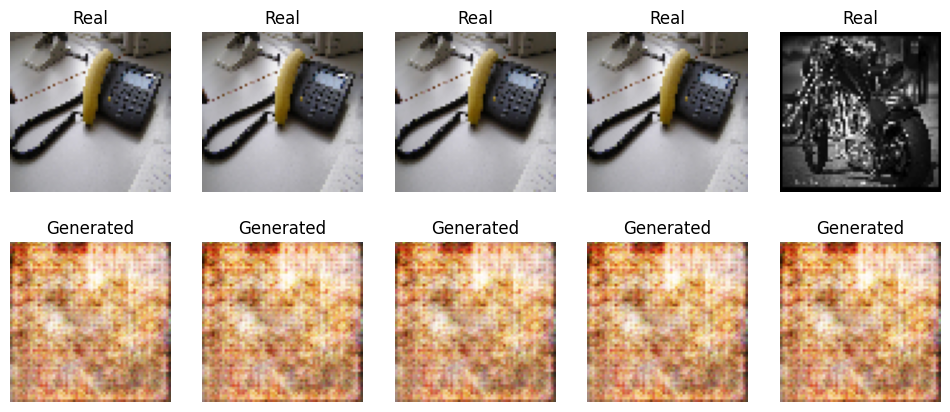

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take a small batch from validation dataset
for text_seq, real_images in val_dataset.take(1):
    batch_size = text_seq.shape[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])
    fake_images = generator([text_seq, noise], training=False)

# Plot first 5 real vs generated
n = 5
plt.figure(figsize=(12, 5))
for i in range(n):
    # Real image
    plt.subplot(2, n, i+1)
    plt.imshow((real_images[i] + 1) / 2)  # scale from [-1,1] to [0,1]
    plt.axis("off")
    plt.title("Real")

    # Generated image
    plt.subplot(2, n, n+i+1)
    plt.imshow((fake_images[i] + 1) / 2)  # scale from [-1,1] to [0,1]
    plt.axis("off")
    plt.title("Generated")

plt.show()

## Hyperparameter Tuning

In [ ]:
param_grid = {
    "learning_rate": [0.0001, 0.0002, 0.0003],
    "NOISE_DIM": [50, 100, 128],
    "embedding_dim": [64, 128, 256],
    "batch_size": [16, 32, 64]
}

In [ ]:
import random

num_trials= 5
trials= []

for a in range(num_trials):
  trial= {k: random.choice(v) for k, v in param_grid.items()}
  trials.append(trial)

for i, t in enumerate(trials):
  print(f"Trial{i+1}: {t}")

Trial1: {'learning_rate': 0.0001, 'NOISE_DIM': 50, 'embedding_dim': 128, 'batch_size': 32}
Trial2: {'learning_rate': 0.0002, 'NOISE_DIM': 128, 'embedding_dim': 64, 'batch_size': 16}
Trial3: {'learning_rate': 0.0002, 'NOISE_DIM': 50, 'embedding_dim': 256, 'batch_size': 32}
Trial4: {'learning_rate': 0.0003, 'NOISE_DIM': 100, 'embedding_dim': 256, 'batch_size': 64}
Trial5: {'learning_rate': 0.0002, 'NOISE_DIM': 128, 'embedding_dim': 128, 'batch_size': 16}



=== Trial 1 ===
{'learning_rate': 0.0001, 'NOISE_DIM': 50, 'embedding_dim': 128, 'batch_size': 32}

Epoch 1/5
Generator Loss: 4.5563 | Discriminator Loss: 0.4573

Epoch 2/5
Generator Loss: 2.3466 | Discriminator Loss: 0.6587

Epoch 3/5
Generator Loss: 2.1609 | Discriminator Loss: 0.6318

Epoch 4/5
Generator Loss: 2.1654 | Discriminator Loss: 0.6625

Epoch 5/5
Generator Loss: 2.3020 | Discriminator Loss: 0.5664
Generating sample images for validation...


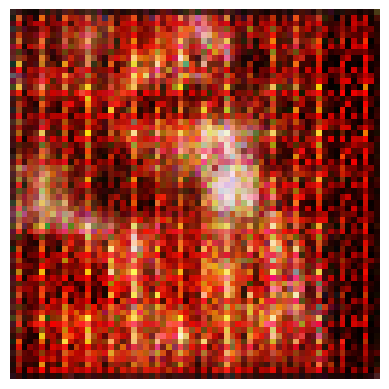

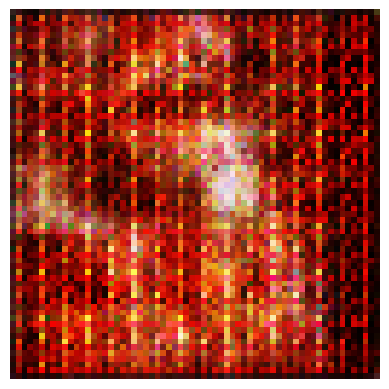

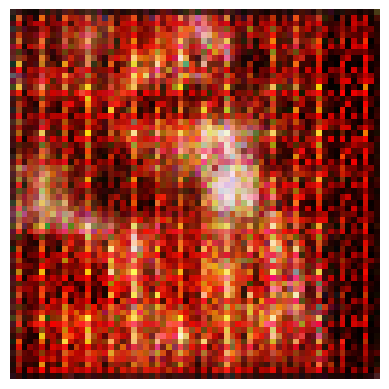


=== Trial 2 ===
{'learning_rate': 0.0002, 'NOISE_DIM': 128, 'embedding_dim': 64, 'batch_size': 16}

Epoch 1/5
Generator Loss: 4.2617 | Discriminator Loss: 0.6575

Epoch 2/5
Generator Loss: 2.5795 | Discriminator Loss: 0.6871

Epoch 3/5
Generator Loss: 2.4221 | Discriminator Loss: 0.6474

Epoch 4/5
Generator Loss: 1.8565 | Discriminator Loss: 0.7800

Epoch 5/5
Generator Loss: 1.8216 | Discriminator Loss: 0.7871
Generating sample images for validation...


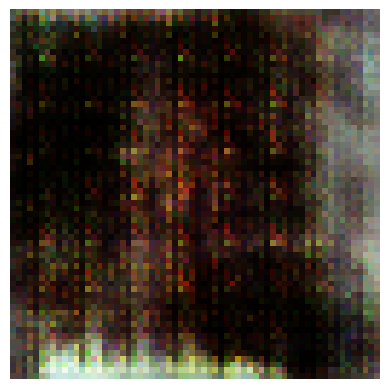

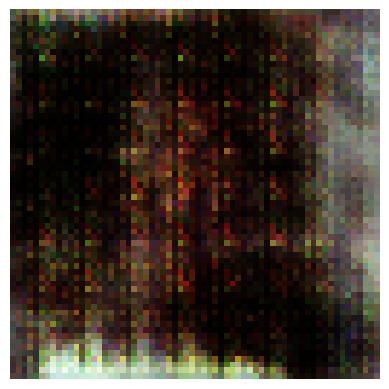

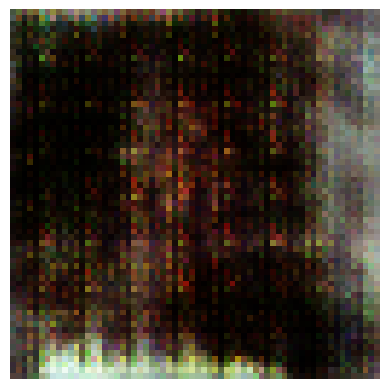


=== Trial 3 ===
{'learning_rate': 0.0002, 'NOISE_DIM': 50, 'embedding_dim': 256, 'batch_size': 32}

Epoch 1/5
Generator Loss: 3.8552 | Discriminator Loss: 0.7488

Epoch 2/5
Generator Loss: 1.8642 | Discriminator Loss: 0.8533

Epoch 3/5
Generator Loss: 1.8729 | Discriminator Loss: 0.9160

Epoch 4/5
Generator Loss: 1.5375 | Discriminator Loss: 0.8816

Epoch 5/5
Generator Loss: 1.5342 | Discriminator Loss: 0.9902
Generating sample images for validation...


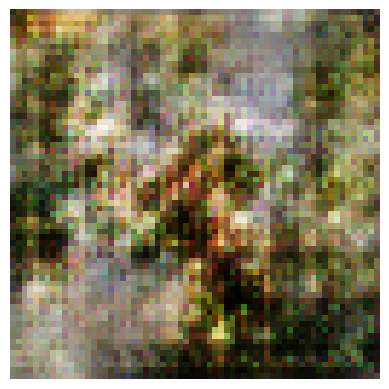

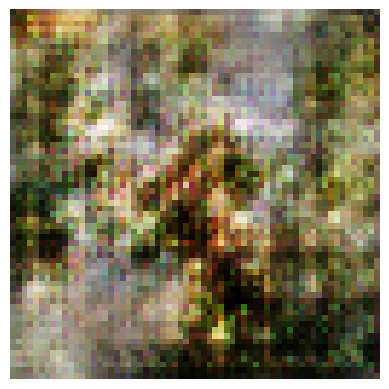

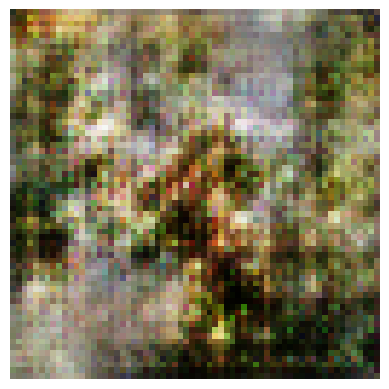


=== Trial 4 ===
{'learning_rate': 0.0003, 'NOISE_DIM': 100, 'embedding_dim': 256, 'batch_size': 64}

Epoch 1/5
Generator Loss: 6.9874 | Discriminator Loss: 0.7094

Epoch 2/5
Generator Loss: 6.7682 | Discriminator Loss: 0.0825

Epoch 3/5
Generator Loss: 7.1976 | Discriminator Loss: 0.0082

Epoch 4/5
Generator Loss: 8.1664 | Discriminator Loss: 0.0045

Epoch 5/5
Generator Loss: 16.1869 | Discriminator Loss: 0.6005
Generating sample images for validation...


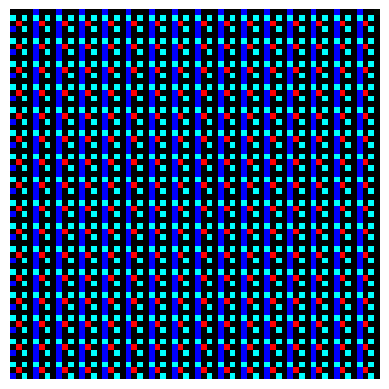

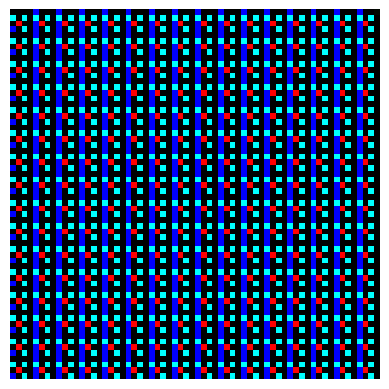

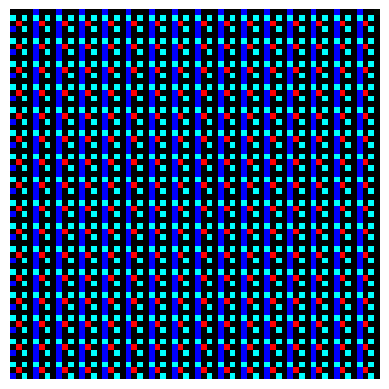


=== Trial 5 ===
{'learning_rate': 0.0002, 'NOISE_DIM': 128, 'embedding_dim': 128, 'batch_size': 16}

Epoch 1/5
Generator Loss: 4.4395 | Discriminator Loss: 0.6654

Epoch 2/5
Generator Loss: 1.8766 | Discriminator Loss: 0.8881

Epoch 3/5
Generator Loss: 2.1311 | Discriminator Loss: 0.8252

Epoch 4/5
Generator Loss: 1.8277 | Discriminator Loss: 0.8272

Epoch 5/5
Generator Loss: 1.9153 | Discriminator Loss: 0.8483
Generating sample images for validation...


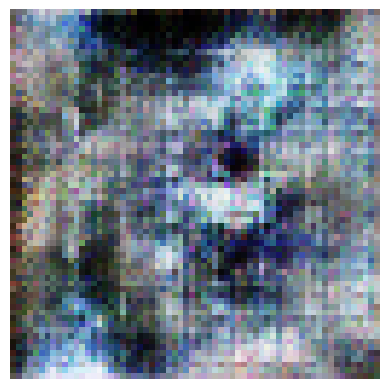

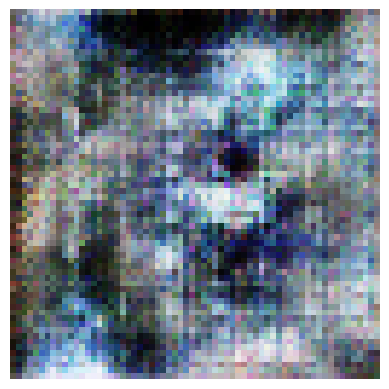

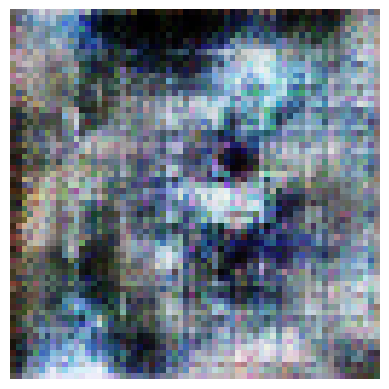


Best Trial:
{'trial': 3, 'hyperparameters': {'learning_rate': 0.0002, 'NOISE_DIM': 50, 'embedding_dim': 256, 'batch_size': 32}, 'generator_loss': np.float64(1.534202892559405), 'discriminator_loss': np.float64(0.9902292074867711)}


In [ ]:
# Random search over 5 hyperparameter trials
results = []

for i, trial in enumerate(trials):
    print(f"\n=== Trial {i+1} ===")
    print(trial)

    # Build models with current trial's embedding_dim and noise_dim
    generator = build_generator(
        noise_dim=trial["NOISE_DIM"],
        embed_dim=trial["embedding_dim"]
    )
    discriminator = build_discriminator(
        embed_dim=trial["embedding_dim"]
    )

    # Prepare optimizers with current learning_rate
    gen_optimizer = tf.keras.optimizers.Adam(trial["learning_rate"], beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(trial["learning_rate"], beta_1=0.5)

    # Prepare datasets with current batch_size
    train_ds = train_dataset
    val_ds = val_dataset

    # Train GAN with current hyperparameters
    generator, discriminator, gen_loss, disc_loss = train_gan(
        train_ds, val_ds,
        generator, discriminator,
        noise_dim=trial["NOISE_DIM"],
        gen_optimizer=gen_optimizer,
        disc_optimizer=disc_optimizer,
        epochs=5
    )

    # Generate a few images from validation set
    print("Generating sample images for validation...")
    for text_seq, _ in val_ds.take(1):
        noise = tf.random.normal([text_seq.shape[0], trial["NOISE_DIM"]])
        fake_images = generator([text_seq, noise], training=False)

        import matplotlib.pyplot as plt
        for j in range(min(3, fake_images.shape[0])):
            plt.imshow((fake_images[j].numpy() + 1)/2)
            plt.axis('off')
            plt.show()

    # Record trial results
    results.append({
        "trial": i+1,
        "hyperparameters": trial,
        "generator_loss": gen_loss,
        "discriminator_loss": disc_loss
    })

# Find trial with lowest generator loss
best_trial = min(results, key=lambda x: x["generator_loss"])
print("\nBest Trial:")
print(best_trial)


In [ ]:
trials

[{'learning_rate': 0.0001,
  'NOISE_DIM': 50,
  'embedding_dim': 128,
  'batch_size': 32},
 {'learning_rate': 0.0002,
  'NOISE_DIM': 128,
  'embedding_dim': 64,
  'batch_size': 16},
 {'learning_rate': 0.0002,
  'NOISE_DIM': 50,
  'embedding_dim': 256,
  'batch_size': 32},
 {'learning_rate': 0.0003,
  'NOISE_DIM': 100,
  'embedding_dim': 256,
  'batch_size': 64},
 {'learning_rate': 0.0002,
  'NOISE_DIM': 128,
  'embedding_dim': 128,
  'batch_size': 16}]

In [ ]:
import os
import tensorflow as tf

# Best hyperparameters from trial 3
best_hp = {
    "learning_rate": 0.0002,
    "NOISE_DIM": 50,
    "embedding_dim": 256,
    "batch_size": 32
}

# Rebuild generator and discriminator
generator = build_generator(noise_dim=best_hp["NOISE_DIM"], embed_dim=best_hp["embedding_dim"])
discriminator = build_discriminator(embed_dim=best_hp["embedding_dim"])

# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(best_hp["learning_rate"], beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(best_hp["learning_rate"] * 0.5, beta_1=0.5)

# Train dataset (already batched)
train_ds = train_dataset
val_ds = val_dataset

# Set number of epochs
EPOCHS = 60

# Directory to save checkpoints
ckpt_dir = "/content/drive/MyDrive/COCO/text2image_gan/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_gen_loss = float("inf")

# Binary crossentropy loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_gen_loss = 0
    train_disc_loss = 0

    for step, (text_seq, real_images) in enumerate(train_ds):
        batch_size = text_seq.shape[0]
        noise = tf.random.normal([batch_size, best_hp["NOISE_DIM"]])

        with tf.GradientTape(persistent=True) as tape:
            fake_images = generator([text_seq, noise], training=True)
            real_output = discriminator([real_images, text_seq], training=True)
            fake_output = discriminator([fake_images, text_seq], training=True)

            real_labels = tf.ones_like(real_output) * 0.9  # label smoothing
            fake_labels = tf.zeros_like(fake_output)

            disc_loss = bce(real_labels, real_output) + bce(fake_labels, fake_output)
            gen_loss = bce(tf.ones_like(fake_output), fake_output)

        gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
        disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

        train_gen_loss += gen_loss.numpy()
        train_disc_loss += disc_loss.numpy()

    train_gen_loss /= tf.data.experimental.cardinality(train_ds).numpy()
    train_disc_loss /= tf.data.experimental.cardinality(train_ds).numpy()
    print(f"Generator Loss: {train_gen_loss:.4f} | Discriminator Loss: {train_disc_loss:.4f}")

    # Save generator if it's the best so far
    if train_gen_loss < best_gen_loss:
        best_gen_loss = train_gen_loss
        checkpoint_path = os.path.join(ckpt_dir, f"best_generator_epoch{epoch+1}.keras")
        generator.save(checkpoint_path)
        print(f"--> Saved new best generator checkpoint at epoch {epoch+1} (loss={best_gen_loss:.4f})")

# Save final models regardless
generator.save("/content/drive/MyDrive/COCO/text2image_gan/final_generator.keras")
discriminator.save("/content/drive/MyDrive/COCO/text2image_gan/final_discriminator.keras")
print("\nTraining complete. Final models saved.")


Epoch 1/60
Generator Loss: 2.6975 | Discriminator Loss: 0.7820
--> Saved new best generator checkpoint at epoch 1 (loss=2.6975)

Epoch 2/60
Generator Loss: 1.5109 | Discriminator Loss: 1.0379
--> Saved new best generator checkpoint at epoch 2 (loss=1.5109)

Epoch 3/60
Generator Loss: 1.5184 | Discriminator Loss: 1.0882

Epoch 4/60
Generator Loss: 1.1992 | Discriminator Loss: 1.1805
--> Saved new best generator checkpoint at epoch 4 (loss=1.1992)

Epoch 5/60
Generator Loss: 1.1692 | Discriminator Loss: 1.1904
--> Saved new best generator checkpoint at epoch 5 (loss=1.1692)

Epoch 6/60
Generator Loss: 1.2565 | Discriminator Loss: 1.1589

Epoch 7/60
Generator Loss: 1.2771 | Discriminator Loss: 1.1535

Epoch 8/60
Generator Loss: 1.2545 | Discriminator Loss: 1.1691

Epoch 9/60
Generator Loss: 1.2275 | Discriminator Loss: 1.1722

Epoch 10/60
Generator Loss: 1.2182 | Discriminator Loss: 1.1671

Epoch 11/60
Generator Loss: 1.2631 | Discriminator Loss: 1.1466

Epoch 12/60
Generator Loss: 1.337

In [30]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Load best generator checkpoint ---
best_generator = load_model("/content/drive/MyDrive/COCO/text2image_gan/checkpoints/best_generator_epoch5.keras")

# --- Hyperparameters ---
best_hp = {
    "learning_rate": 0.0002,
    "NOISE_DIM": 50,
    "embedding_dim": 256,
    "batch_size": 32
}

# --- Rebuild discriminator ---
discriminator = build_discriminator(embed_dim=best_hp["embedding_dim"])

# --- Optimizers ---
gen_optimizer = tf.keras.optimizers.Adam(best_hp["learning_rate"], beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(best_hp["learning_rate"] * 0.25, beta_1=0.5)  # weaker discriminator

# --- Binary crossentropy loss ---
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# --- Training datasets ---
train_ds = train_dataset  # your prepared training dataset
val_ds = val_dataset      # your validation dataset

# --- Training parameters ---
EPOCHS_BURST = 10  # small burst
ckpt_dir = "/content/drive/MyDrive/COCO/text2image_gan/checkpoints_resumed"
os.makedirs(ckpt_dir, exist_ok=True)
best_gen_loss = float("inf")

# --- Burst training loop ---
for epoch in range(EPOCHS_BURST):
    print(f"\nEpoch {epoch+1}/{EPOCHS_BURST}")
    train_gen_loss = 0
    train_disc_loss = 0

    for step, (text_seq, real_images) in enumerate(train_ds):
        batch_size = text_seq.shape[0]
        noise = tf.random.normal([batch_size, best_hp["NOISE_DIM"]])

        # --- Discriminator step ---
        with tf.GradientTape() as disc_tape:
            fake_images = best_generator([text_seq, noise], training=True)
            real_output = discriminator([real_images, text_seq], training=True)
            fake_output = discriminator([fake_images, text_seq], training=True)

            real_labels = tf.ones_like(real_output) * 0.9  # label smoothing
            fake_labels = tf.zeros_like(fake_output)

            disc_loss = bce(real_labels, real_output) + bce(fake_labels, fake_output)

        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

        # --- Generator step ---
        train_G_times = 1
        if disc_loss.numpy() < 0.35:  # discriminator too strong
            train_G_times = 2

        for _ in range(train_G_times):
            with tf.GradientTape() as gen_tape:
                fake_images = best_generator([text_seq, noise], training=True)
                fake_output = discriminator([fake_images, text_seq], training=True)
                gen_loss = bce(tf.ones_like(fake_output), fake_output)
            gen_grads = gen_tape.gradient(gen_loss, best_generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_grads, best_generator.trainable_variables))

        train_gen_loss += gen_loss.numpy()
        train_disc_loss += disc_loss.numpy()

    # --- Average losses ---
    train_gen_loss /= tf.data.experimental.cardinality(train_ds).numpy()
    train_disc_loss /= tf.data.experimental.cardinality(train_ds).numpy()
    print(f"Generator Loss: {train_gen_loss:.4f} | Discriminator Loss: {train_disc_loss:.4f}")

    # --- Save generator if best so far ---
    if train_gen_loss < best_gen_loss:
        best_gen_loss = train_gen_loss
        checkpoint_path = os.path.join(ckpt_dir, f"best_generator_resumed_epoch{epoch+1}.keras")
        best_generator.save(checkpoint_path)
        print(f"--> Saved new best generator checkpoint at epoch {epoch+1} (loss={best_gen_loss:.4f})")

# --- Save final models after this burst ---
best_generator.save("/content/drive/MyDrive/COCO/text2image_gan/final_generator_resumed.keras")
discriminator.save("/content/drive/MyDrive/COCO/text2image_gan/final_discriminator_resumed.keras")
print("\nBurst training complete. Models saved.")


Epoch 1/10
Generator Loss: 1.2987 | Discriminator Loss: 1.3862
--> Saved new best generator checkpoint at epoch 1 (loss=1.2987)

Epoch 2/10
Generator Loss: 1.1546 | Discriminator Loss: 1.4043
--> Saved new best generator checkpoint at epoch 2 (loss=1.1546)

Epoch 3/10
Generator Loss: 1.1097 | Discriminator Loss: 1.3386
--> Saved new best generator checkpoint at epoch 3 (loss=1.1097)

Epoch 4/10
Generator Loss: 1.1050 | Discriminator Loss: 1.3337
--> Saved new best generator checkpoint at epoch 4 (loss=1.1050)

Epoch 5/10
Generator Loss: 1.0574 | Discriminator Loss: 1.3480
--> Saved new best generator checkpoint at epoch 5 (loss=1.0574)

Epoch 6/10
Generator Loss: 1.0865 | Discriminator Loss: 1.3149

Epoch 7/10
Generator Loss: 1.1662 | Discriminator Loss: 1.3212

Epoch 8/10
Generator Loss: 1.2059 | Discriminator Loss: 1.2605

Epoch 9/10
Generator Loss: 1.2887 | Discriminator Loss: 1.2210

Epoch 10/10
Generator Loss: 1.6737 | Discriminator Loss: 1.1312

Burst training complete. Models s

In [31]:
from tensorflow.keras.models import load_model

final_generator = load_model("/content/drive/MyDrive/COCO/text2image_gan/checkpoints_resumed/best_generator_resumed_epoch5.keras")

In [32]:
#Saving a copy for deployment
final_generator.save("/content/drive/MyDrive/COCO/text2image_gan/final_generator_stable.keras")
discriminator.save("/content/drive/MyDrive/COCO/text2image_gan/final_discriminator_stable.keras")

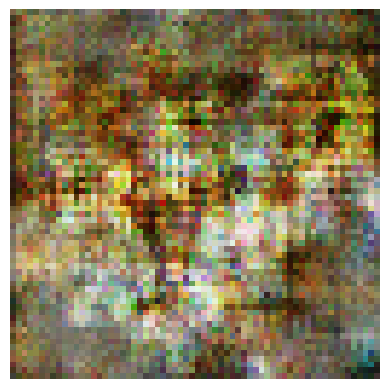

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Example: generate one image
text_seq = next(iter(val_ds))[0]  # pick one text batch from validation
noise = tf.random.normal([text_seq.shape[0], 50])

generated_images = final_generator([text_seq, noise], training=False)

# Display first image
plt.imshow((generated_images[0].numpy() * 0.5 + 0.5))  # rescale to [0,1] if using tanh
plt.axis('off')
plt.show()

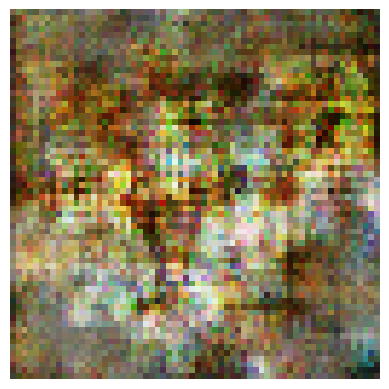

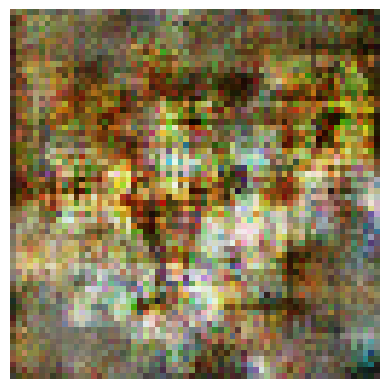

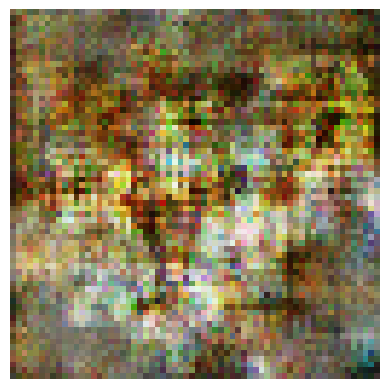

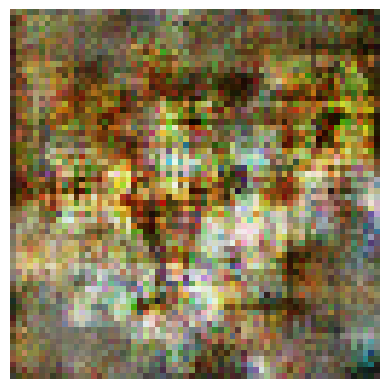

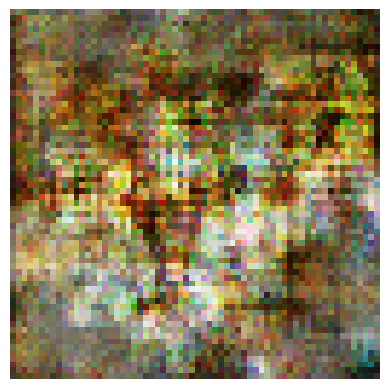

In [34]:
num_samples = 5
text_seq = next(iter(val_ds))[0]  # batch of text sequences
noise = tf.random.normal([num_samples, best_hp["NOISE_DIM"]])
generated_images = final_generator([text_seq[:num_samples], noise], training=False)

import matplotlib.pyplot as plt
for i in range(num_samples):
    plt.figure()
    plt.imshow((generated_images[i].numpy() * 0.5 + 0.5))  # rescale if using tanh
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.2, so it will not be used.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

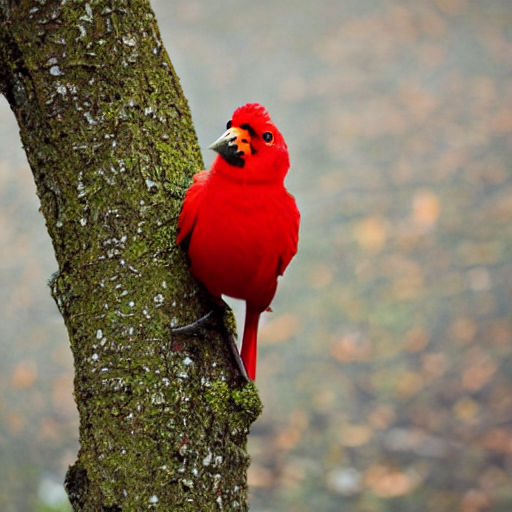

  0%|          | 0/50 [00:00<?, ?it/s]

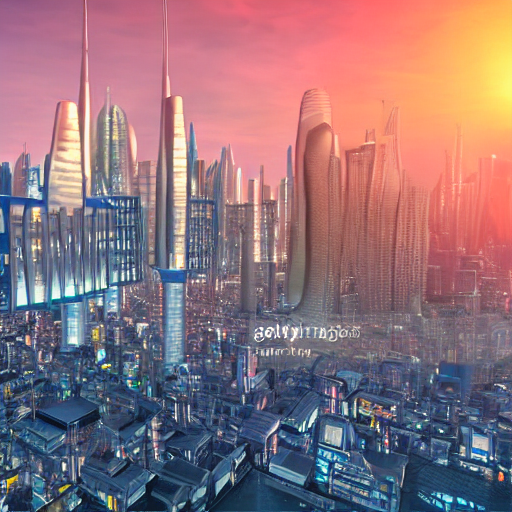

In [1]:
import os
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import display

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda") if torch.cuda.is_available() else pipe

prompts = ["A red bird on a tree", "A futuristic city skyline at sunset"]
os.makedirs("p_outputs", exist_ok=True)

for idx, prompt in enumerate(prompts):
    image = pipe(prompt).images[0]
    image.save(f"p_outputs/sample_{idx+1}.png")
    display(image)

In [4]:
import os
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import display

def generate_images(prompts, output_dir="generated_images", use_cuda=True):
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
    if use_cuda and torch.cuda.is_available():
        pipe = pipe.to("cuda")
    else:
        pipe = pipe.to("cpu")

    os.makedirs(output_dir, exist_ok=True)
    generated_images = []

    for idx, prompt in enumerate(prompts):
        image = pipe(prompt).images[0]
        image_path = os.path.join(output_dir, f"sample_{idx+1}.png")
        image.save(image_path)
        display(image)
        generated_images.append(image)

    return generated_images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

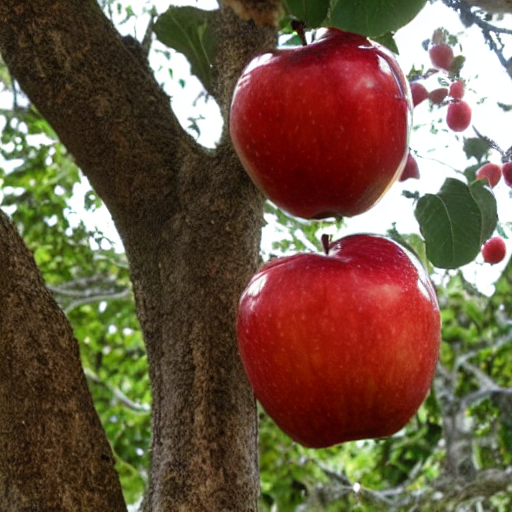

  0%|          | 0/50 [00:00<?, ?it/s]

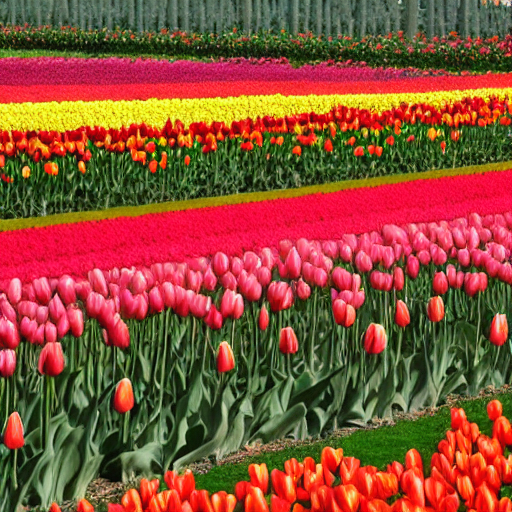

In [13]:
# Example usage
prompts = ["A red apple on a tree", "Tulip garden"]
images = generate_images(prompts, output_dir="p_outputs")